In [174]:
import psycopg2
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from create_staging_tables import create_loyalty_scores_df
from clean_for_model import prepare_bill_text_for_clean_df
from stage_predict import stage_score_plot

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
engine = create_engine('postgresql://localhost:5432/wa_leg_staging')

In [3]:
merged_final_df = pd.read_sql_query('select * from "merged_final"',con=engine)
rep_score_df = pd.read_sql_query('select * from "rep_score"',con=engine)

In [4]:
bill_text_df = pd.read_sql_query('select * from "bill_text"',con=engine)

In [5]:
bill_text_df_new = prepare_bill_text_for_clean_df(bill_text_df)

In [6]:
def create_clean_X(merged_final_df, bill_text_df, rep_score_df):
    
    # Add bill_text
    clean = merged_final_df.merge(bill_text_df, how='left', on=['unique_id', 'htm_url'])
    clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    clean.rename(columns={'sponsor_party': 'primary_sponsor_party'}, inplace=True)

    
    # Add rep_score and replace -1 values, then make dem_score
    clean['bill_num'] = clean['bill_id'].apply(lambda x: x.split()[1])
    clean['bill_num_unique'] = clean['biennium'] + ' ' + clean['bill_num']
    clean = clean.merge(rep_score_df, how='left', on='bill_num_unique')

    def replace_with_p_sponsor_party(row):
        primary_sponsor_party = row['primary_sponsor_party']
        if row['rep_score'] == -1:
            return primary_sponsor_party
        else:
            return row['rep_score']
    clean['rep_score'] = clean.apply(replace_with_p_sponsor_party, axis=1)
    clean['dem_score'] = 1 - clean['rep_score']
    
    
    # Add loyalty scores
#     clean = clean.merge(loyalty_df, how = 'left', on='voter_id')
#     clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    
    
    # Feature Engineering functions
    def create_congress_nums(biennium):
        '''Numbers bienniums so that 1991 is 1 and 1993 is 3.'''
        first_year = int((biennium.split('-'))[0])
        return first_year - 1990
    
    def find_num_sponsors(secondary_sponsors):
        if type(secondary_sponsors) == str:
            return round((len(secondary_sponsors) / 5) + 1)
        else: return 1
        
    def remove_neg(num):
        if num < 0:
            return 0
        else: return num
        
    def count_sections(bill_text):
        sections = []
        for count in range(1, 20):
            section_indicator = '({})'.format(count)
            if section_indicator in bill_text:
                sections.append(count)
        if len(sections) == 0:
            return 0
        return np.max(sections)
    
    # Feature Engineering
    clean['bill_length'] = clean['bill_text'].apply(lambda x: len(x))
    clean['num_sections'] = clean['bill_text'].apply(count_sections)
    clean['congress_num'] = clean['biennium'].apply(create_congress_nums)
    clean['num_sponsors'] = clean['secondary_sponsors'].apply(find_num_sponsors)
    
    clean['vote_year'] = clean['vote_date'].apply(lambda x: x.year)
    clean['first_year_read'] = clean['first_date_read'].apply(lambda x: x.year)
    clean['first_year_read'] = clean['first_year_read'].fillna(clean['vote_year'])
    clean['years_until_vote'] = clean['vote_year'] - clean['first_year_read']
    clean['years_until_vote'] = clean['years_until_vote'].apply(remove_neg)
    
    return clean

In [7]:
clean = create_clean_X(merged_final_df, bill_text_df_new, rep_score_df)

In [8]:
clean.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote
0,1,1993-02-16,347,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,"{445,309,339,562}",562,0.5,0.5,33244,3,4,1993,1993.0,0.0
1,1,1993-02-16,360,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,"{445,309,339,562}",562,0.5,0.5,33244,3,4,1993,1993.0,0.0
2,1,1993-02-16,361,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,"{445,309,339,562}",562,0.5,0.5,33244,3,4,1993,1993.0,0.0
3,1,1993-02-16,387,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,"{445,309,339,562}",562,0.5,0.5,33244,3,4,1993,1993.0,0.0
4,1,1993-02-16,512,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,"{445,309,339,562}",562,0.5,0.5,33244,3,4,1993,1993.0,0.0


In [296]:
def get_bill_type(bill_id):
    bill_type = (bill_id.split(' '))[0]
    return bill_type

In [297]:
clean['bill_type'] = clean['bill_id'].apply(get_bill_type)

In [303]:
grouped = clean.groupby('bill_type').mean()

In [305]:
bill_type_series = grouped['vote']

In [314]:
bill_type_dct = bill_type_df.to_dict()

In [315]:
clean['bill_type_score'] = clean['bill_type'].apply(lambda x: bill_type_dct[x])

In [316]:
clean

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,num_sections,bill_type,bill_type_score
0,1,1993-02-16,347,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.500000,33244,3,4,1993,1993.0,0.0,9,SB,0.980216
1,1,1993-02-16,360,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.500000,33244,3,4,1993,1993.0,0.0,9,SB,0.980216
2,1,1993-02-16,361,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.500000,33244,3,4,1993,1993.0,0.0,9,SB,0.980216
3,1,1993-02-16,387,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.500000,33244,3,4,1993,1993.0,0.0,9,SB,0.980216
4,1,1993-02-16,512,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.500000,33244,3,4,1993,1993.0,0.0,9,SB,0.980216
5,1,1993-02-16,399,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.500000,33244,3,4,1993,1993.0,0.0,9,SB,0.980216
6,1,1993-02-16,402,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.500000,33244,3,4,1993,1993.0,0.0,9,SB,0.980216
7,1,1993-02-16,403,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.500000,33244,3,4,1993,1993.0,0.0,9,SB,0.980216
8,1,1993-02-16,405,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.500000,33244,3,4,1993,1993.0,0.0,9,SB,0.980216
9,1,1993-02-16,409,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.500000,33244,3,4,1993,1993.0,0.0,9,SB,0.980216


In [ ]:
# def flip_vote(vote):
#     if vote == 1:
#         return 0
#     if vote == 0:
#         return 1
#     else:
#         return vote

In [ ]:
# clean['vote'] = clean['vote'].apply(flip_vote)

### Dummies

In [ ]:
# clean_new = clean.copy()

In [ ]:
# Dummy Options
#     district_dummies = pd.get_dummies(clean_new['district'])
#     clean_dist_dum = clean_new.merge(district_dummies, right_index=True, left_index=True)

# voter_id_dummies = pd.get_dummies(clean_new['voter_id'])
# clean_voter_dum = clean_new.merge(voter_id_dummies, right_index=True, left_index=True)

# Make Sample

### All bienniums

In [320]:
sample = clean.sample(n=300000)
sample = sample[sample['vote'] <= 1]
sample.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,num_sections,bill_type,bill_type_score
1827388,1,2006-02-10,142,1,2005-06 SSB 5838,59733.0,2005-06,SSB 5838,http://app.leg.wa.gov/documents/billdocs/2005-...,1,...,0.666667,1233,15,9,2006,2005.0,1.0,2,SSB,0.962221
530541,1,1992-03-12,205,0,1991-92 ESB 6284,6504.0,1991-92,ESB 6284,http://app.leg.wa.gov/documents/billdocs/1991-...,1,...,0.500000,804,1,3,1992,1992.0,0.0,1,ESB,0.895844
3170730,1,2018-03-08,12003,1,2017-18 SSB 6340,106424.0,2017-18,SSB 6340,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.800000,1459,27,12,2018,2018.0,0.0,2,SSB,0.962221
2699819,1,2014-03-06,5880,1,2013-14 ESHB 2315,88670.0,2013-14,ESHB 2315,http://app.leg.wa.gov/documents/billdocs/2013-...,0,...,0.812500,15234,23,20,2014,2014.0,0.0,11,ESHB,0.861423
2263799,1,2010-02-13,2314,0,2009-10 SHB 2420,73454.0,2009-10,SHB 2420,http://app.leg.wa.gov/documents/billdocs/2009-...,0,...,0.611111,19737,19,20,2010,2010.0,0.0,9,SHB,0.970059


In [321]:
sample_train = sample[sample['vote_date'] < '2017-07-01T00:00:00.000000000']
sample_test = sample[sample['vote_date'] > '2017-07-01T00:00:00.000000000']

In [322]:
loyalty_scores_df = create_loyalty_scores_df(sample_train)

In [323]:
# Add loyalty scores to train
sample_train = sample_train.merge(loyalty_scores_df, how = 'left', on='voter_id')

In [324]:
sample_train = sample_train.drop('index', axis=1)

In [325]:
loy_dem_average = np.mean(sample_train[sample_train['party'] == 0]['loyalty_score'])
loy_rep_average = np.mean(sample_train[sample_train['party'] == 1]['loyalty_score'])

In [326]:
yea_dem_average = np.mean(sample_train[sample_train['party'] == 0]['percent_yea'])
yea_rep_average = np.mean(sample_train[sample_train['party'] == 1]['percent_yea'])

In [327]:
loy_dem_average, loy_rep_average

(0.2465524658387564, -0.1768678716688964)

In [328]:
# Add loyalty scores to test
sample_test = sample_test.merge(loyalty_scores_df, how = 'left', on='voter_id')
sample_test = sample_test.drop('index', axis=1)

In [329]:
sample_test['loyalty_score'] = sample_test['loyalty_score'].fillna(1000)
sample_test['percent_yea'] = sample_test['percent_yea'].fillna(1000)

In [330]:
def fillna_loyalty(row):
    if row['loyalty_score'] == 1000:
        if row['party'] == 0:
            return loy_dem_average
        if row['party'] ==1:
            return loy_rep_average
    else:
        return row['loyalty_score']

In [331]:
def fillna_percent_yea(row):
    if row['percent_yea'] == 1000:
        if row['party'] == 0:
            return yea_dem_average
        if row['party'] ==1:
            return yea_rep_average
    else:
        return row['percent_yea']

In [332]:
sample_test['loyalty_score'] = sample_test.apply(fillna_loyalty, axis=1)
# sample_test['percent_yea'] = sample_test.apply(fillna_percent_yea, axis=1)

In [333]:
sample_test

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,num_sections,bill_type,bill_type_score,loyalty_score,percent_yea
0,1,2018-03-08,12003,1,2017-18 SSB 6340,106424.0,2017-18,SSB 6340,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,27,12,2018,2018.0,0.0,2,SSB,0.962221,0.440308,0.920110
1,1,2018-02-13,1407,1,2017-18 SB 6351,106441.0,2017-18,SB 6351,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,27,4,2018,2018.0,0.0,12,SB,0.980216,0.322967,0.891674
2,1,2018-01-11,14205,0,2017-18 HB 1715,101390.0,2017-18,HB 1715,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,27,55,2018,2017.0,1.0,7,HB,0.980661,0.391633,0.949565
3,1,2018-02-28,18546,0,2017-18 2SSB 6274,106310.0,2017-18,2SSB 6274,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,27,13,2018,2018.0,0.0,16,2SSB,0.922806,0.278138,0.949791
4,1,2018-03-01,17217,1,2017-18 SHB 2951,103569.0,2017-18,SHB 2951,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,27,19,2018,2018.0,0.0,3,SHB,0.970059,-0.097268,0.926641
5,1,2018-02-08,15809,0,2017-18 SHB 2514,102814.0,2017-18,SHB 2514,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,27,15,2018,2018.0,0.0,8,SHB,0.970059,0.365654,0.907317
6,0,2018-02-14,15817,0,2017-18 E3SHB 1144,100141.0,2017-18,E3SHB 1144,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,27,17,2018,2018.0,0.0,5,E3SHB,0.685796,0.364142,0.944828
7,1,2018-02-27,9207,0,2017-18 SSB 6055,105853.0,2017-18,SSB 6055,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,27,6,2018,2018.0,0.0,3,SSB,0.962221,0.406571,0.936864
8,1,2018-02-27,20757,0,2017-18 SSB 6147,106052.0,2017-18,SSB 6147,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,27,12,2018,2018.0,0.0,3,SSB,0.962221,-0.211391,0.807292
9,1,2018-02-12,27988,0,2017-18 HB 2446,102710.0,2017-18,HB 2446,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,27,9,2018,2018.0,0.0,14,HB,0.980661,-0.176868,1000.000000


In [466]:
clean['bill_length'].min()

0

### Only 2017-18

In [ ]:
sample_one_year = clean[clean['biennium'] == '2017-18']
sample_one_year = sample_one_year[sample_one_year['vote'] <= 1]
sample_one_year.head()

In [ ]:
sample_one_year_train = sample_one_year[sample_one_year['vote_date'] < '2018-02-22T00:00:00.000000000']
sample_one_year_test = sample_one_year[sample_one_year['vote_date'] > '2018-02-22T00:00:00.000000000']

### Voter_id dummies

In [ ]:
sample_one_year_voterdum = clean_voter_dum[clean_voter_dum['biennium'] == '2017-18']
sample_one_year_voterdum = sample_one_year_voterdum[sample_one_year_voterdum['vote'] <= 1]
# X = sample_one_year_voterdum.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id', 'htm_url',
#                                    'bill_text', 'bill_num', 'bill_num_unique', 'secondary_sponsors', 
#                                    'primary_sponsor_id', 'congress_num', 'num_sponsors'], axis=1)
sample_one_year_voterdum.head()

# Modeling

### Baseline Model

In [334]:
# TRAIN
X_train_b = sample_train[['primary_sponsor_party', 'party']]
y_train_b = sample_train['vote']

# TEST
X_test_b = sample_test[['primary_sponsor_party', 'party']]
y_test_b = sample_test['vote']

# X_base = sample[['primary_sponsor_party', 'party']]
# y_base = sample['vote']
# X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.30, random_state=709)

In [335]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train_b, y_train_b)
y_pred_b = (baseline_model.predict_proba(X_test_b))[:,1]

In [336]:
y_pred_b.max()

0.9345316880111711

In [337]:
log_loss(y_test_b, y_pred_b)

0.4086570786455452

In [338]:
roc_auc_b = roc_auc_score(y_test_b, y_pred_b)
fpr_b, tpr_b, thresholds_b = roc_curve(y_test_b, y_pred_b)

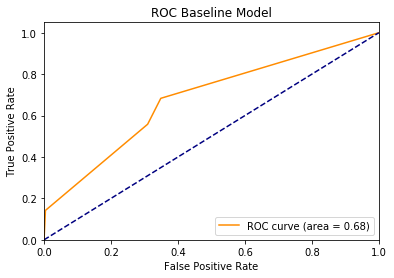

In [339]:
fig, ax = plt.subplots()
plt.plot(fpr_b, tpr_b, color='darkorange', label= f'ROC curve (area = {round(roc_auc_b, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Baseline Model')
plt.legend(loc="lower right")
plt.show()

### Current Top Model - rep and loyalty scores

In [348]:
# TRAIN
X_train_t = sample_train[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'num_sections', 'bill_type_score']]

y_train_t = sample_train['vote']

# TEST
X_test_t = sample_test[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'num_sections', 'bill_type_score']]

y_test_t = sample_test['vote']

In [481]:
top_model = RandomForestClassifier(n_estimators=3000, max_depth=11, n_jobs=2, random_state=709)
top_model.fit(X_train_t, y_train_t)
y_pred_t = (top_model.predict_proba(X_test_t))[:, 1]

# 1000, 12 -.8003, .3442, .258
# 1500 11 - .801, .3442, .288

In [482]:
log_loss(y_test_t, y_pred_t)

0.3442896255095844

In [483]:
y_pred_t.min()

0.29008838814856824

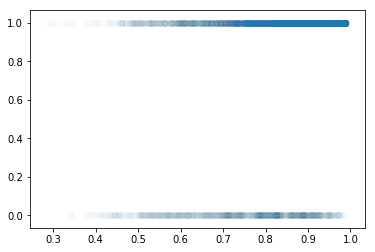

In [484]:
fig, ax = plt.subplots()
ax.scatter(y_pred_t, y_test_t, alpha=0.01)

In [485]:
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t, y_pred_t)

In [486]:
roc_auc_t = roc_auc_score(y_test_t, y_pred_t)
roc_auc_t

0.8009864213810359

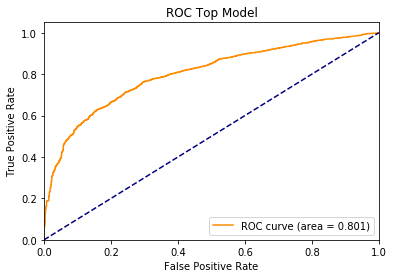

In [487]:
fig, ax = plt.subplots()
plt.plot(fpr_t, tpr_t, color='darkorange', label= f'ROC curve (area = {round(roc_auc_t, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Top Model')
plt.legend(loc="lower right")
plt.show()

### Trying out new model

In [357]:
# TRAIN
X_train_n = sample_train[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'num_sections', 'bill_type_score']]

y_train_n = sample_train['vote']

# TEST
X_test_n = sample_test[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'num_sections', 'bill_type_score']]

y_test_n = sample_test['vote']

In [420]:
new_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=25, max_depth=6, random_state=709, 
                                       verbose=1)
#0.05, 43, 5 - .795, .299

In [421]:
new_model.fit(X_train_n, y_train_n)

      Iter       Train Loss   Remaining Time 
         1           0.6288           25.99s
         2           0.6196           23.76s
         3           0.6114           22.31s
         4           0.6045           22.82s
         5           0.5984           21.72s
         6           0.5930           20.29s
         7           0.5881           19.02s
         8           0.5838           17.87s
         9           0.5797           16.86s
        10           0.5758           15.93s
        20           0.5475            5.20s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=25,
              presort='auto', random_state=709, subsample=1.0, verbose=1,
              warm_start=False)

25


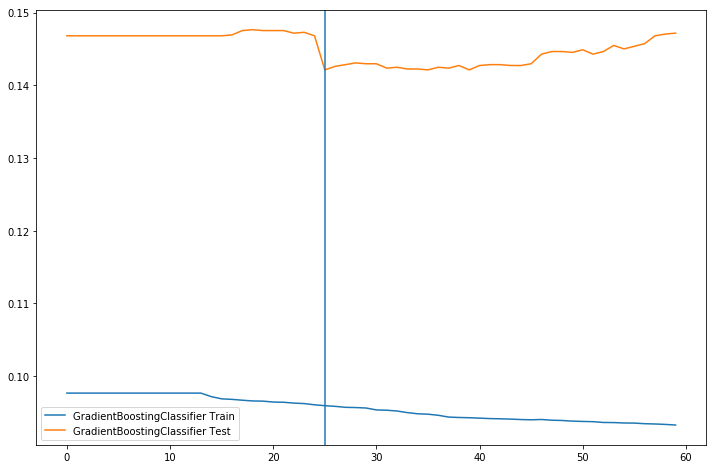

In [419]:
fig, ax = plt.subplots(figsize=(12, 8))
stage_score_plot(new_model, X_train_n, y_train_n, X_test_n, y_test_n, ax)
ax.legend()
plt.show()

In [422]:
y_pred_n = (new_model.predict_proba(X_test_n))[:, 1]

In [423]:
log_loss(y_test_n, y_pred_n)

0.3521900021383175

In [424]:
y_pred_n.min()

0.37285957888024013

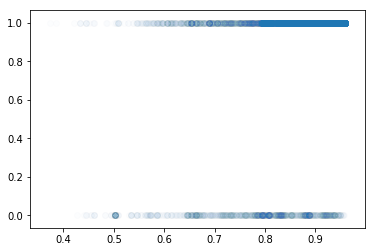

In [425]:
fig, ax = plt.subplots()
ax.scatter(y_pred_n, y_test_n, alpha=0.01)

In [426]:
fpr_n, tpr_n, thresholds_n = roc_curve(y_test_n, y_pred_n)

In [427]:
roc_auc_n = roc_auc_score(y_test_n, y_pred_n)
roc_auc_n

0.7985873138706923

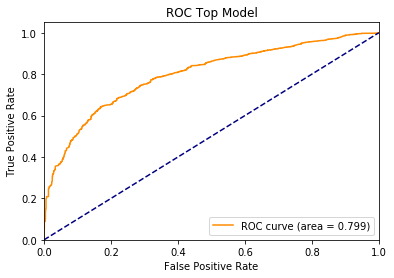

In [428]:
fig, ax = plt.subplots()
plt.plot(fpr_n, tpr_n, color='darkorange', label= f'ROC curve (area = {round(roc_auc_n, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Top Model')
plt.legend(loc="lower right")
plt.show()

# Model records

In [ ]:
new_model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=91, max_depth=9, random_state=709, 
                                       verbose=1)

roc_auc = .78498
log_loss = .3637
min = .369




new_model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=91, max_depth=7, random_state=709, 
                                       verbose=1)

roc_auc = .78324
log_loss = .3629
min = .41838




new_model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=91, max_depth=11, random_state=709, 
                                       verbose=1)

roc_auc = .77574
log_loss = .3720
min = .3577



new_model = GradientBoostingClassifier(learning_rate=0.005, n_estimators=178, max_depth=9, random_state=709, 
                                       verbose=1)

roc_auc = .7806
log_loss = .36646
min = .3902



new_model = GradientBoostingClassifier(learning_rate=0.005, n_estimators=148, max_depth=10, random_state=709, 
                                       verbose=1)

roc_auc = .779673
log_loss = .3697
min = .4287

In [177]:
GBC_grid = {'learning_rate': [0.01],
            'n_estimators': [100, 300, 500, 800, 1000],
            'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
            'max_features': ['sqrt', 'log2', None],
            'min_samples_leaf': [1, 2, 4, 6],
            'random_state': [709]}

GBC_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                             GBC_grid,
                             n_jobs=-1,
                             verbose=True)
GBC_gridsearch.fit(X_train_n, y_train_n)

print("best parameters:", GBC_gridsearch.best_params_)

best_GBC_model = GBC_gridsearch.best_estimator_

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 104.0min


KeyboardInterrupt: 

In [170]:
GradientBoostingClassifier?

### NLP Playground

In [429]:
# TRAIN
X_train = sample_train[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_train = sample_train['vote']

# TEST
X_test = sample_test[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_test = sample_test['vote']

In [430]:
bills = sample_train['bill_text']
bills_test = sample_test['bill_text']
len(bills)

283316

In [433]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.85, max_features=8000)

In [434]:
fitted = tf.fit(bills)

KeyboardInterrupt: 

In [ ]:
transformed_train = tf.transform(bills)

In [ ]:
transformed_test = tf.transform(bills_test)

In [ ]:
def tfidf_transformed_to_dataframe(transformed):
    tfidf_cols = transformed.toarray()
    tfidf_names = fitted.get_feature_names()
    tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

    return tfidf_df

In [ ]:
tfidf_train_df = tfidf_transformed_to_dataframe(transformed_train)
X_train = X_train.reset_index().drop('index', axis=1)
X_train = pd.concat([X_train, tfidf_train_df], axis=1)

In [ ]:
tfidf_test_df =  tfidf_transformed_to_dataframe(transformed_test)
X_test = X_test.reset_index().drop('index', axis=1)
X_test = pd.concat([X_test, tfidf_test_df], axis=1)

In [ ]:
X_train.head()

In [ ]:
model = RandomForestClassifier(n_estimators=5000, max_depth=7, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [ ]:
log_loss(y_test, y_pred)

In [ ]:
y_pred.min()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [ ]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [ ]:
X_train.columns

In [ ]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [ ]:
features_importances_sorted

### Topic Playground

In [ ]:
topic_df = pd.read_csv('topic_staging_better.csv', sep="|")

In [ ]:
topic_df['bill_num_unique'] = topic_df['biennium'] + ' ' + topic_df['bill_num'].apply(str)

In [ ]:
topic_df = topic_df.drop('biennium', axis=1)

In [ ]:
MERGD = sample_train.merge(topic_df, how='left', on='bill_num_unique')

In [ ]:
MERGD_train = MERGD[MERGD['bill_id_y'].notnull()]

In [ ]:
MERGD_test = sample_test.merge(topic_df, how='left', on='bill_num_unique')

In [ ]:
MERGD_test = MERGD_test[MERGD_test['bill_id_y'].notnull()]

In [ ]:
MERGD_train.columns

In [ ]:
# X_train_t = sample_train[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
#                      'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
#                      'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
#                      'num_sponsors', 'years_until_vote']]

In [ ]:
# TRAIN
X_train = MERGD_train.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id_x', 'bill_id_y', 'htm_url',
                            'bill_text', 'first_date_read', 'bill_num_unique', 'secondary_sponsors', 
                            'primary_sponsor_id', 'congress_num', 'dem_score', 'vote_year', 'first_year_read'], 
                             axis=1)

y_train = MERGD_train['vote']

# TEST
X_test = MERGD_test.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id_x','bill_id_y', 'htm_url',
                          'bill_text', 'first_date_read', 'bill_num_unique', 'secondary_sponsors', 
                          'primary_sponsor_id', 'congress_num', 'dem_score', 'vote_year', 'first_year_read'], 
                           axis=1)

y_test = MERGD_test['vote']

In [ ]:
model = RandomForestClassifier(n_estimators=2000, max_depth=6, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [ ]:
log_loss(y_test, y_pred)

In [ ]:
y_pred.min()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [ ]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [ ]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [ ]:
features_importances_sorted[0:20]

In [ ]:
group = sample_train.groupby('vote')

In [ ]:
group.mean()

# Model to Pickle

# Explore bill_text

In [64]:
nays = sample[sample['vote'] == 0]
yeas = sample[sample['vote'] == 1]

yeas.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote
3097375,1,2018-03-01,1659,0,2017-18 SHB 2998,103639.0,2017-18,SHB 2998,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,"{15817,1543,9207,15816,18265}",18265,0.00,1.00,3180,27,7,2018,2018.0,0.0
881032,1,1998-02-10,1585,0,1997-98 SHB 2672,25621.0,1997-98,SHB 2672,http://app.leg.wa.gov/documents/billdocs/1997-...,0,...,"{2153,2174,1592,406,382,1594}",1594,0.50,0.50,1667,7,7,1998,1998.0,0.0
3151171,1,2018-02-27,13198,0,2017-18 SSB 5996,105726.0,2017-18,SSB 5996,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,"{1407,5155,5156,12003,12002,15821,27290,21520,...",1950,0.00,1.00,2548,27,12,2018,2018.0,0.0
2432392,1,2011-03-03,1659,0,2011-12 HB 1178,79451.0,2011-12,HB 1178,http://app.leg.wa.gov/documents/billdocs/2011-...,0,...,"{3478,10031}",10031,0.25,0.75,13506,21,3,2011,2011.0,0.0
1670454,1,2005-03-11,972,0,2005-06 SHB 1394,54299.0,2005-06,SHB 1394,http://app.leg.wa.gov/documents/billdocs/2005-...,0,...,"{2314,2166,8237,972}",972,0.25,0.75,12451,15,5,2005,2005.0,0.0


In [65]:
nays.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote
2997634,0,2018-02-27,17217,1,2017-18 EHB 1237,100330.0,2017-18,EHB 1237,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,"{18057,9207,17307,10031,3483,16462,17224,10039...",9997,0.095238,0.904762,12836,27,25,2018,2017.0,1.0
3151895,0,2018-02-27,15809,0,2017-18 ESSB 6002,105739.0,2017-18,ESSB 6002,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,"{1407,5155,14325,17226,27211,14074,13546,12003...",27290,0.000000,1.000000,32142,27,25,2018,2018.0,0.0
1376648,0,2001-03-13,633,1,2001-02 SSB 5965,43637.0,2001-02,SSB 5965,http://app.leg.wa.gov/documents/billdocs/2001-...,1,...,"{2153,2304,644,347,409}",409,0.000000,1.000000,3761,11,6,2001,2001.0,0.0
2394363,0,2010-03-05,9550,0,2009-10 ESSB 6444,78003.0,2009-10,ESSB 6444,http://app.leg.wa.gov/documents/billdocs/2009-...,1,...,"{8214,337}",337,0.250000,0.750000,744659,19,3,2010,2010.0,0.0
2235843,0,2009-03-09,3478,0,2009-10 ESHB 1939,72569.0,2009-10,ESHB 1939,http://app.leg.wa.gov/documents/billdocs/2009-...,0,...,"{12084,9997,2166,9207,8420,2144,10039,8212,347...",10249,0.214286,0.785714,19888,19,16,2009,2009.0,0.0


In [ ]:
Read first time
BE IT ENACTED
AN ACT

Passed the house

In [67]:
print(yeas.loc[3097375, 'bill_text'])

 to providing a business and occupation tax exemption for accountable communities of health; adding a new section to chapter 82.04 rcw; creating new sections; and declaring an emergency.be it enacted by the legislature of the state of washington:new section.  sec. 1.  (1) this section is the tax preference performance statement for the tax preference contained in section 2, chapter . . ., laws of 2018 (section 2 of this act). the performance statement is only intended to be used for subsequent evaluation of the tax preference. it is not intended to create a private right of action by any party or be used to determine eligibility for preferential tax treatment.(2) the legislature categorizes this tax preference as one intended to reduce structural inefficiencies in the tax structure under rcw 82.32.808(2)(d).(3) the legislature acknowledges the importance of accountable communities of health under rcw 41.05.800 in aligning actions to achieve healthy communities and populations, improvin

In [68]:
print(nays.loc[2235843, 'bill_text'])

 to vehicle dealer documentary service fees; and amending rcw 46.70.180.be it enacted by the legislature of the state of washington:sec. 1 rcw 46.70.180 and 2007 c 155 s 2 are each amended to read as follows:     each of the following acts or practices is unlawful:     (1) to cause or permit to be advertised, printed, displayed, published, distributed, broadcasted, televised, or disseminated in any manner whatsoever, any statement or representation with regard to the sale, lease, or financing of a vehicle which is false, deceptive, or misleading, including but not limited to the following:     (a) that no down payment is required in connection with the sale of a vehicle when a down payment is in fact required, or that a vehicle may be purchased for a smaller down payment than is actually required;     (b) that a certain percentage of the sale price of a vehicle may be financed when such financing is not offered in a single document evidencing the entire security transaction;     (c) th

In [ ]:
bill_text_df.head()

In [ ]:
bill_text_df_test

In [ ]:
example_text = yeas.loc[402049, 'bill_text']

In [ ]:
example_text = example_text.lower()

In [ ]:
(example_text.split('first time')[1])[0:20]

### TFIDFVectorizer

In [ ]:
bills = sample_one_year['bill_text']

In [ ]:
bills.shape

In [ ]:
wordnet = WordNetLemmatizer()

In [ ]:
def create_bill_tokens(bill):
    bill = bill.replace('\n', ' ') 
    punctuations = set(string.punctuation)
    
    bill = ''.join([char.lower() for char in bill if char not in punctuations])
    bill_tokens = bill.split(' ')
    lemmed_bill = [wordnet.lemmatize(word) for word in bill_tokens] 
    
    return lemmed_bill

In [432]:
my_stopwords = ['shall', 'chapter', 'provided', 'year', 'person', 'department', 'appropriation', 'provided'
                 'information', 'provide', 'including', 'following', 'section', 'sec', 'year', 'subsection', 
                'agency', 'required',  'use', 'solely', 'ii', 'defined', 'approved', 'does',  'period', 
                'rcw 43', 'persons', 'individual', 'unless', '9a', '28a', 'purpose', '28b',  'washington',  
                'fy',  'iii', 'sec rcw', 'rcw9a', 'rcw',  'apply',  '000general',  '000', 'related',  'sp', 
                'make', 'includes', 'end', 'biennia', 'set', 'terms', 'total', 'level', 'amended', 
                'engrossed', 'substitute', 'legislature', 'enacted', 'passed', 'add', 'additional', 'new', 'board',
                'limited', 'date', 'order', 'plan', 'percent', 'support', 'director', 'child', 'two', 'years', 
                'committee', 'five', 'laws', 'contract', 'prior', 'necessary', 'requirements', 'days', 'based', 
                'made', 'except', 'per', 'number', 'amounts', 'conditions', 'senate', 'house', 'system', 'may',
               'must', 'account', 'one', 'means', 'within', 'county', 'general', 'subject', 'within', 'treatment', 
               'service', 'include', 'used', 'account', 'less', 'part', 'member', 'established', 'law', 'rate', 
                'read', 'follows', 'information', 'program', 'services', 'fund', 'amount', 'agreement', 'payment',
               'commission', 'notice', 'legislature2015', '02', '1st', 'april', 'beginning', 'december', 'january', 
                'february', 'march', 'may', 'june', 'july', 'august', 'sepetmeber', 'november', 'manner', 'plans',
               'need', '060', 'sections', 'either', 'described', 'equivalent', 'recommendations', 'office', 'created',
               'higher', 'hours', 'written', 'address', 'organizations', 'value', 'party', 'full', '030', 'high', 'case',
               'four', '04', 'would', '05', 'day', 'whether', 'pass', '040', 'yeas', 'nays', 'absents', 'yea', 'nay',
                'absents', 'undecided', 'undecideds']

stop_nums = list(set([str(num) for num in range(0, 2025)]))
stopwords_nltk = list(set(stopwords.words('english')))

stopwords_nltk.extend(my_stopwords)
stopwords_nltk.extend(stop_nums)
stopwords_nltk = set(stopwords_nltk)

In [ ]:
analyzer=create_bill_tokens, 

In [ ]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.9, max_features=5000)
fitted = tf.fit(bills)
transformed = tf.transform(bills)
fitted = tf.fit(bills)
transformed = tf.transform(bills)
vocab = tf.vocabulary_
vocab

tfidf_cols = transformed.toarray()

tfidf_names = fitted.get_feature_names()

tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

tfidf_df.head()

tfidf_df.shape

In [ ]:
fitted = tf.fit(bills)

In [ ]:
transformed = tf.transform(bills)

In [ ]:
vocab = tf.vocabulary_

In [ ]:
vocab

In [ ]:
tfidf_cols = transformed.toarray()

In [ ]:
tfidf_names = fitted.get_feature_names()

In [ ]:
tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

In [ ]:
tfidf_df.head()

In [ ]:
tfidf_df.shape

In [ ]:
# cv = CountVectorizer(stop_words=stopwords_nltk, analyzer='word', ngram_range=(1, 4), max_df=0.9, max_features = 200000)
# cv_fit = cv.fit_transform(bills)
# word_counts = pd.DataFrame(cv_fit.toarray(), columns= cv.get_feature_names())
# word_counts = word_counts.sum(axis=0)
# words_sorted = word_counts.sort_values(ascending=False)
# words_sorted_only = words_sorted.index
# for word in words_sorted_only [100:150]:
#     print(word)

In [ ]:
features_importances_sorted[0:50]